#<center>**Solution for "Predict Future Sales" Kaggle Competition**</center>

#####<center>Competition Link: https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales</center>

In [ ]:
# Importing the libraries

import pandas as pd
import numpy as np
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product

import pickle

In [ ]:
#Function for reducing the size of a dataframe for a better memory usage

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the data

DATA_FOLDER = '/content/drive/MyDrive/Kaggle_Competition/Data'

train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
test_data = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv')).set_index('ID')
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

print(train_data.shape, test_data.shape, items.shape, item_categories.shape, shops.shape)

(2935849, 6) (214200, 2) (22170, 3) (84, 2) (60, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


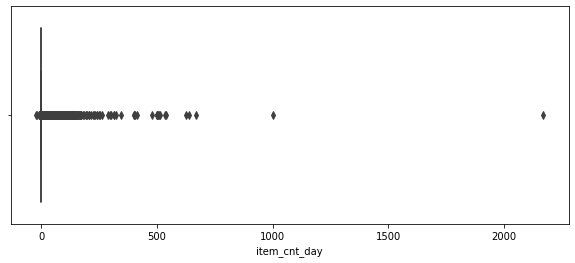

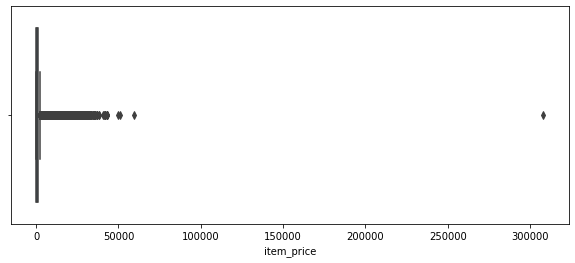

In [ ]:
#Exploratory Data Analysis (EDA)

#Visualization of the count and price of items per each sample of the training dataset using 'Boxplot'
plt.figure(figsize=(10,4))
sns.boxplot(train_data.item_cnt_day)

plt.figure(figsize=(10,4))
sns.boxplot(x=train_data.item_price)

In [ ]:
#Remove the outliers detected from the above visualization

train_data = train_data[train_data.item_cnt_day<1001]
train_data = train_data[train_data.item_price<100000]

(array([1.608553e+06, 3.780000e+02, 8.800000e+01, 5.600000e+01,
        2.700000e+01, 8.000000e+00, 8.000000e+00, 3.000000e+00,
        0.000000e+00, 2.000000e+00]),
 array([ -22. ,  144.6,  311.2,  477.8,  644.4,  811. ,  977.6, 1144.2,
        1310.8, 1477.4, 1644. ]),
 <a list of 10 Patch objects>)

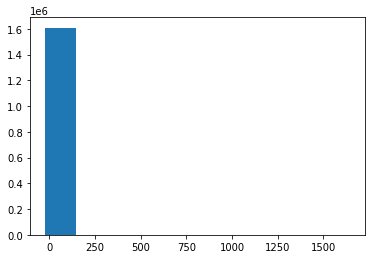

In [ ]:
#Visualization of the training target values

target_visualize = train_data.groupby(['shop_id', 'item_id', 'date_block_num']).agg({'item_cnt_day': 'sum'})
plt.hist(target_visualize.values) #The values are clustered in one range, so clipping of the target values would be required

(array([1062322.,  368729.,   85301.,   34791.,   17970.,   10496.,
           6765.,    4524.,    3327.,   14898.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

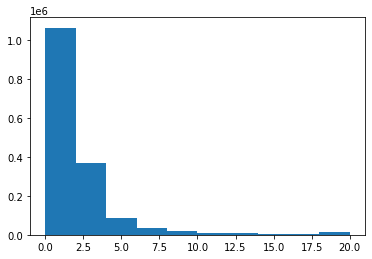

In [ ]:
#Visualization of the training target values after clipping from 0 to 20

target_visualize_clip = train_data.groupby(['shop_id', 'item_id', 'date_block_num']).agg({'item_cnt_day': 'sum'}).clip(0, 20)
plt.hist(target_visualize_clip.values) #The values are now distributed in a better way

In [ ]:
#Extra data cleaning steps

median = train_data[(train_data.shop_id == 32) & (train_data.item_id == 2973) & (train_data.date_block_num == 4) & (
            train_data.item_price > 0)].item_price.median()
train_data.loc[train_data.item_price < 0, 'item_price'] = median

train_data.loc[train_data.shop_id == 0, 'shop_id'] = 57
test_data.loc[test_data.shop_id == 0, 'shop_id'] = 57
train_data.loc[train_data.shop_id == 1, 'shop_id'] = 58
test_data.loc[test_data.shop_id == 1, 'shop_id'] = 58
train_data.loc[train_data.shop_id == 10, 'shop_id'] = 11
test_data.loc[test_data.shop_id == 10, 'shop_id'] = 11

In [ ]:
#Feature Extraction - "Month" and "Year" Features

#"Month" and "Year" are simple features that we can add to our model given that we know the month and the year of the testing data
train_data[['day', 'month', 'year']] = train_data['date'].str.split('.', expand=True)
train_data['year'] = train_data['year'].astype(int)
train_data['month'] = train_data['month'].astype(int)

In [ ]:
#Feature Extraction - Simple Features

#We can create a matrix/grid for all the shops/items combinations at a certain month

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'month', 'year', 'date_block_num']

# Creating the feature matrix
grid = [] 
for block_num in train_data['date_block_num'].unique():
    cur_shops = train_data.loc[train_data['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train_data.loc[train_data['date_block_num'] == block_num, 'item_id'].unique()
    cur_month = train_data.loc[train_data['date_block_num'] == block_num, 'month'].unique()
    cur_year = train_data.loc[train_data['date_block_num'] == block_num, 'year'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, cur_month, cur_year, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Creating the "target" column and a feature to represent the price mean of an item at a shop per month
gb = train_data.groupby(index_cols).agg({'item_cnt_day': 'sum', 'item_price': 'mean'})
gb = gb.reset_index()
gb = gb.rename(columns={'item_cnt_day': 'target', 'item_price': 'item_price_mean'})

# Join the created feature and target column to the grid
train_data_monthly = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Adding the testing data to the feature grid
test_data['date_block_num'] = 34
test_data['year'] = 2015
test_data['month'] = 11
train_data_monthly = pd.concat([train_data_monthly, test_data], ignore_index=True, sort=False, keys=index_cols)
train_data_monthly.fillna(0, inplace=True)

# Add a feature of the "Category ID" for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
train_data_monthly = pd.merge(train_data_monthly, item_category_mapping, how='left', on='item_id')
train_data = pd.merge(train_data, item_category_mapping, on=['item_id'], how='left')

# Add a feature of mean of number of items sold for each shop per month
gb = train_data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day':[('shop_block_target_mean',np.mean)]})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
train_data_monthly = pd.merge(train_data_monthly, gb, how='left', on=['date_block_num', 'shop_id']).fillna(0)

# Add a feature of mean of number of items/pieces sold for each item per month
gb = train_data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day':[('item_block_target_mean',np.mean)]})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
train_data_monthly = pd.merge(train_data_monthly, gb, how='left', on=['date_block_num', 'item_id']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(train_data_monthly)
del grid, gb 
gc.collect();

In [ ]:
# Feature Extraction - "Lag" Features

# List of columns that we will use to create lags
index_cols = ['shop_id', 'item_id', 'date_block_num', 'item_category_id']
cols_to_rename = list(all_data.columns.difference(['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'month', 'year'])) 

# Create lag features from 1, 2, 3, 6, and 12 months ago
shift_range = [1, 2, 3, 6, 12]
for month_shift in tqdm_notebook(shift_range):
    train_shift = train_data_monthly[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    train_data_monthly = pd.merge(train_data_monthly, train_shift, on=index_cols, how='left').fillna(0)
del train_shift

# Remove old data from year 2013
train_data_monthly = train_data_monthly[train_data_monthly['date_block_num'] >= 12] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Feature Extraction - "Mean Encoding" Features

# Generate features using mean encoding of three variables (item ID, shop ID, and item category ID)

# First clip the target values for the generation of the mean encodings
train_data_monthly['target'] = train_data_monthly['target'].clip(0, 20)

# Mean encoding of "item_id" feature
train_data_monthly['mean_encode_item'] = train_data_monthly.groupby('item_id')['target'].transform('mean')
train_data_monthly['mean_encode_item'].fillna(train_data_monthly['target'].values.mean(), inplace = True)

# Mean encoding of "shop_id" feature
train_data_monthly['mean_encode_shop'] = train_data_monthly.groupby('shop_id')['target'].transform('mean')
train_data_monthly['mean_encode_shop'].fillna(train_data_monthly['target'].values.mean(), inplace = True)

# Mean encoding of "item_category_id" feature
train_data_monthly['mean_encode_cat_id'] = train_data_monthly.groupby('item_category_id')['target'].transform('mean')
train_data_monthly['mean_encode_cat_id'].fillna(train_data_monthly['target'].values.mean(), inplace = True)

# Downcast dtypes to save memory
train_data_monthly = downcast_dtypes(train_data_monthly)
gc.collect();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Training and Validation Data Splitting

# Drop columns of "target" and other related features from the training and testing data
to_drop_cols = ['target', 'shop_block_target_mean','item_block_target_mean', 'item_price_mean']

# Train and validation split (the data of the last month was separated to be the validation data)
X_train = train_data_monthly[train_data_monthly.date_block_num < 33].drop(to_drop_cols, axis=1)
y_train = train_data_monthly[train_data_monthly.date_block_num < 33]['target'].clip(0, 20).values
X_valid = train_data_monthly[train_data_monthly.date_block_num == 33].drop(to_drop_cols, axis=1)
y_valid = train_data_monthly[train_data_monthly.date_block_num == 33]['target'].clip(0, 20).values
X_test = train_data_monthly[train_data_monthly.date_block_num == 34].drop(to_drop_cols, axis=1)

In [ ]:
# LightGBM Model Training

# LightGBM model is used and RMSE is used for metric optimization

# Instead of training the model, you can load it from "lgb_model.pkl" as follows: lgb_model = pickle.load(open(os.path.join(DATA_FOLDER, 'lgb_model.pkl'), 'rb'))

lgb_params = {
               'feature_fraction': 0.7,
               'objective': 'rmse',
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 250, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'rmse', 
               'bagging_seed': 2**7, 
               'num_leaves': 200,
               'bagging_freq':5,
               'verbose':0, 
               'force_col_wise' : True,
               'seed':1
              }

lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 2000, 
                          valid_sets = [lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_valid, label=y_valid)], verbose_eval=True, 
                          early_stopping_rounds=20)

pred_lgb = lgb_model.predict(X_valid.values)
print('Test R-squared for LightGBM is %f' % r2_score(y_valid, pred_lgb))

In [ ]:
# Saving the Model

pickle.dump(lgb_model, open(os.path.join(DATA_FOLDER, 'lgb_model.pkl'), 'wb'))

In [ ]:
# Target Prediction of Testing Data using LightLGB Model and Submission File Generation

pred_lgb = lgb_model.predict(X_test.values)

submission = pd.DataFrame({
    "ID": test_data.index, 
    "item_cnt_month": pred_lgb.clip(0, 20) #Predicted target values are clipped from 0 to 20 as done with the training data
})

submission.to_csv(os.path.join(DATA_FOLDER, 'submission_LGB.csv'), index=False)

In [ ]:
# Ensemble Model Training

# Instead of training the ensemble model, you can load it from "ensemble_model.pkl" as follows: lr_ensemble = pickle.load(open(os.path.join(DATA_FOLDER, 'ensemble_model.pkl'), 'rb'))

# Fitting a linear regression model
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_valid.values)
print('Test R-squared for LightGBM is %f' % r2_score(y_valid, pred_lr))

# Combining the predictions of the linear regression model and the LightGBM model
pred_lr = lr.predict(X_test.values)
X_test_level2 = np.c_[pred_lr, pred_lgb]

# Build Level 2 True Targets
train_data_monthly_level2 = train_data_monthly[train_data_monthly.date_block_num >= 27]
y_train_level2 = train_data_monthly_level2[train_data_monthly_level2.date_block_num < 34]['target'].clip(0, 20).values

In [ ]:
# Building Level 2 Training Feature Matrix and Predict its Targets using Cross-validation with Linear Regression and LightGBM Models

X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

for cur_block_num in [27, 28, 29, 30, 31, 32, 33]: 

    print(cur_block_num) 
    
    # Create training and validation splits
    X_train_split = train_data_monthly[train_data_monthly.date_block_num <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_split  = train_data_monthly[train_data_monthly.date_block_num == cur_block_num].drop(to_drop_cols, axis=1)
    y_train_split = train_data_monthly[train_data_monthly.date_block_num <  cur_block_num]['target'].clip(0, 20).values
    y_test_split =  train_data_monthly[train_data_monthly.date_block_num == cur_block_num]['target'].clip(0, 20).values

    # Fitting linear regression model
    lr = LinearRegression()
    lr.fit(X_train_split.values, y_train_split)
    pred_lr = lr.predict(X_test_split.values)
    
    # Fitting LightGBM model
    model = lgb.train(lgb_params, lgb.Dataset(X_train_split, label=y_train_split), 100)
    pred_lgb = model.predict(X_test_split)

    # Combining the predictions of Linear Regression and LightGBM models
    train_data_len = train_data_monthly_level2[train_data_monthly_level2.date_block_num < cur_block_num].shape[0]
    test_data_len = train_data_monthly_level2[train_data_monthly_level2.date_block_num == cur_block_num].shape[0]    
    X_train_level2[train_data_len:train_data_len+test_data_len, 0] = pred_lr
    X_train_level2[train_data_len:train_data_len+test_data_len, 1] = pred_lgb

27
28
29
30
31
32
33


In [ ]:
# Target Prediction of Testing Meta-features using Ensemble Model (Stacking) and Submission File Generation

# Fitting the ensemble model
lr_ensemble = LinearRegression()
lr_ensemble.fit(X_train_level2, y_train_level2)

# Saving the ensemble model
pickle.dump(lr_ensemble, open(os.path.join(DATA_FOLDER, 'ensemble_model.pkl'), 'wb'))

# Predicting the targets of testing meta-features
pred_ens = lr_ensemble.predict(X_test_level2)

submission = pd.DataFrame({
    "ID": test_data.index, 
    "item_cnt_month": pred_ens.clip(0, 20) #Predicted target values are clipped from 0 to 20 as done with the training data
})

submission.to_csv(os.path.join(DATA_FOLDER, 'submission_ENS.csv'), index=False)